Cette partie est une application du début du livre de Christopher M.Bishop "Pattern Recognition and Machine Learning  dans laquelle j'essaie de mettre en pratique ce que j'ai lu. 

En commmencant par du curve fitting sur les données météorologiques à une heure donnée à un lieu donné. Cependant contrairement à précedement, il nous faut utiliser au moins deux années distinctes pour un même endroit pour bien capter la presque-périodicité des données. Sinon un polynome de degré 2 approche très très bien les données sur une année, mais ne permettrait pas de 

I) Polynomial Curve Fitting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
past_forecast = pd.read_csv('hourly_past_predicted_temperature_2m_2023.csv')
historical_data = pd.read_csv('hourly_past_real_temperature_2m_2023.csv')
historical_data = historical_data.rename(columns={historical_data.columns[0]: 'compteur'})
past_forecast = past_forecast.rename(columns={past_forecast.columns[0]: 'compteur'})

past_forecast_provisoire = past_forecast[~(past_forecast["compteur"].isin([8743,8744,8745,8746,8747]))]

In [3]:
past_forecast_provisoire["real_temperature_2m"]=historical_data["real_temperature_2m"]
past_forecast_provisoire["error"]=past_forecast_provisoire["temperature_2m"]-past_forecast_provisoire["real_temperature_2m"]
past_forecast_provisoire["absolute_error"]=abs(past_forecast_provisoire["error"])

In [4]:
past_forecast_provisoire['date'] = pd.to_datetime(past_forecast_provisoire['date'])

In [5]:
fin_apres_midi = past_forecast_provisoire[past_forecast_provisoire["date"].dt.hour == 18]
un_lieu_une_heure = fin_apres_midi.head(365)
un_lieu_une_heure.describe()



,compteur,temperature_2m,latitude,longitude,real_temperature_2m,error,absolute_error
count,365.000000,365.000000,365.0,365.0,365.000000,365.000000,365.000000
mean,4386.000000,11.368763,43.0,-5.0,10.784541,0.584222,1.348156
std,2532.255911,7.706593,0.0,0.0,7.024727,1.639407,1.098813
min,18.000000,-5.318500,43.0,-5.0,-3.714500,-4.553999,0.004000
25%,2202.000000,4.981500,43.0,-5.0,5.485500,-0.454000,0.504000
50%,4386.000000,11.181500,43.0,-5.0,10.935500,0.546000,1.104000
75%,6570.000000,17.431500,43.0,-5.0,15.985499,1.595999,1.845997
max,8754.000000,33.131500,43.0,-5.0,29.385500,6.595999,6.595999


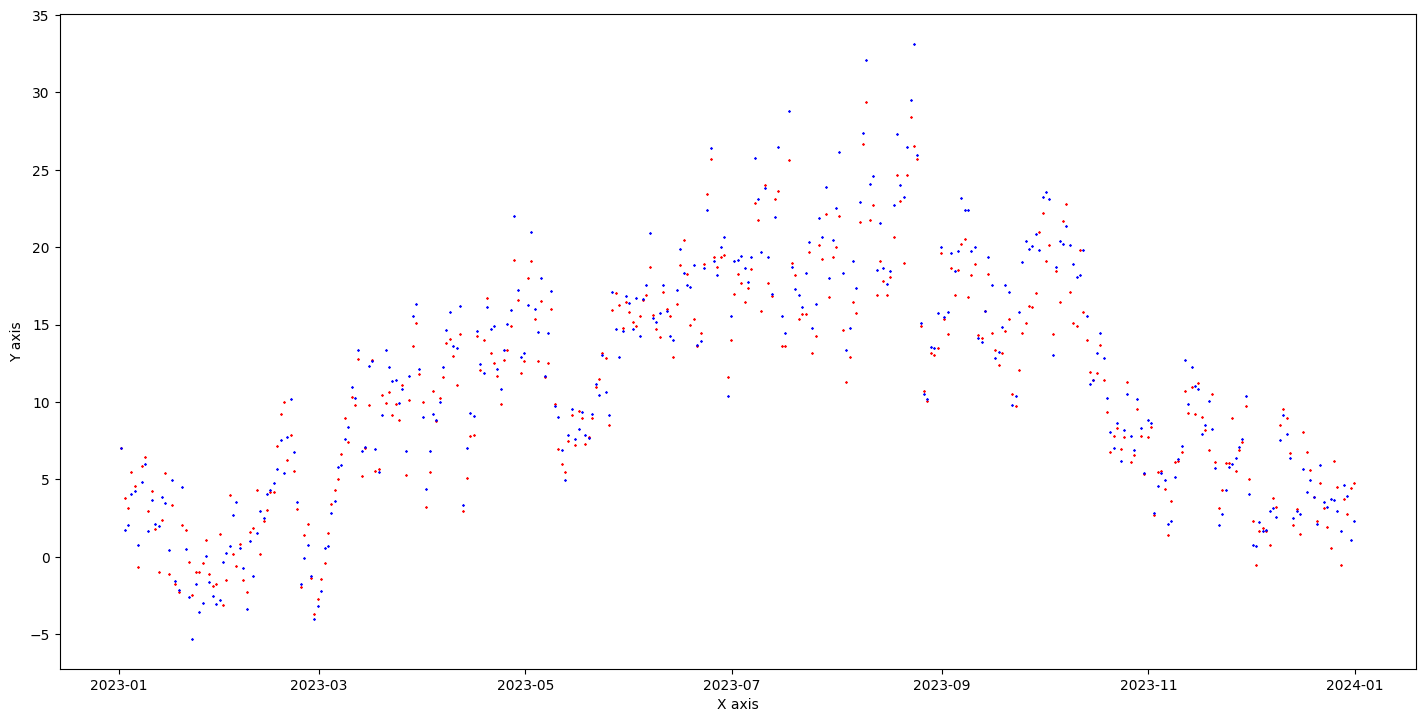

In [6]:
x = un_lieu_une_heure["date"]
y1 = un_lieu_une_heure["real_temperature_2m"]
y2 = un_lieu_une_heure["temperature_2m"]

fig = plt.figure(figsize=(17.5,8.5))

# Scatter plot the points
plt.scatter(x, y1, c='r', marker='X', s=0.5) # température réelle 
plt.scatter(x, y2, c='b', marker='X', s=0.5)  # température prédite par le modèle 

# Set labels
plt.xlabel('X axis')
plt.ylabel('Y axis')


plt.show()

Tentative de curve fitting en codant soit même la fonction polynomiale et la fonction d'erreur (erreur quadratique), en utilisant scipy et minimize pour obtenir les coefficients du polynome minimisant l'erreur 

In [23]:
M=3 #degré du polynome

X=un_lieu_une_heure["temperature_2m"].sample(10).head(10)
T=un_lieu_une_heure["real_temperature_2m"].head(10)

print(X)
def y(x, w): 
    somme=0
    for i in range(M):
        print(i)
        coeff = w[i]*x**i
        somme+=coeff
    return somme 

def error_function(w):
    error=0
    for i in range(len(X)):
        coeff=(y(X[i],w)-T[i])**2
        error+=coeff
    return(1/2 * error)


x0 = np.array([-1,2,-3,10])
result = minimize(error_function, x0)
argmin = result.x
print("Argmin:", argmin)


polynome = np.polynomial.Polynomial(argmin)
x = np.linspace(-10, 10, 1000)
y_value = y(x, argmin) 

plt.plot(x, y_value)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Function Plot')
plt.grid(True)
plt.show()


8274     7.931500
3426    13.031500
5394    21.581500
6618    13.031500
474      0.481500
6210    12.831500
2826    17.231499
1410    -3.218500
7722    10.031500
8370     2.731500
Name: temperature_2m, dtype: float64


KeyError: 0

Utilisation de la fonction curve_fit de scipy :

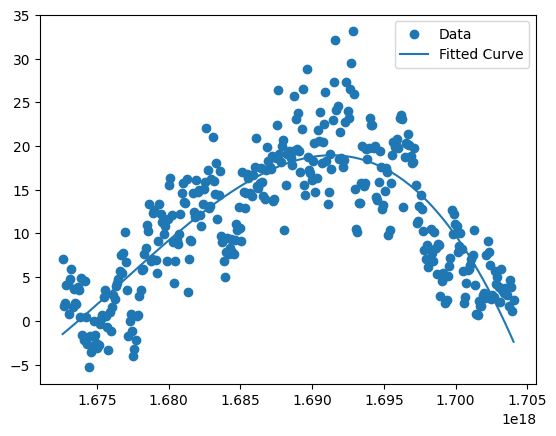

In [16]:
time = un_lieu_une_heure["date"].values.astype(float)
real_values = un_lieu_une_heure["real_temperature_2m"].values
values=un_lieu_une_heure["temperature_2m"].values

def polynomial(x, a, b, c, d):
    return a * x**4 + b * x**3 + c*x**2 + d*x 


# Fit the curve
popt, pcov = curve_fit(polynomial, time, values )

# Plot the data and the fitted curve

plt.scatter(time, values, label='Data')
plt.plot(time, polynomial(time, *popt), label='Fitted Curve')
plt.legend()
plt.show()

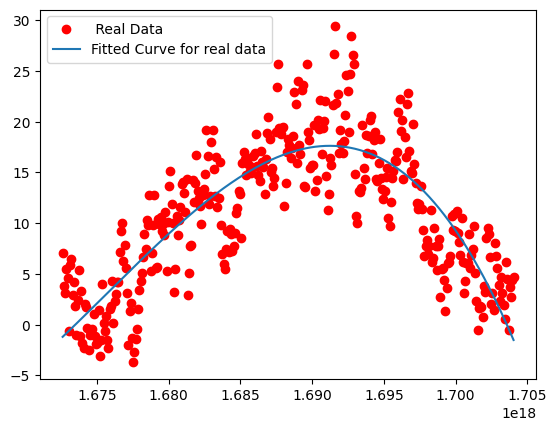

In [18]:
time = un_lieu_une_heure["date"].values.astype(float)
real_values = un_lieu_une_heure["real_temperature_2m"].values

def polynomial(x, a, b, c, d):
    return a * x**4 + b * x**3 + c*x**2 + d*x 

# Fit the curve
popt, pcov = curve_fit(polynomial, time, real_values )

# Plot the data and the fitted curve

plt.scatter(time, real_values, label=' Real Data' , c="r")
plt.plot(time, polynomial(time, *popt), label='Fitted Curve for real data')
plt.legend()
plt.show()


Comparaison des fonctions polynomiales approchant les données prédites (en marron) et réelle (en bleu)

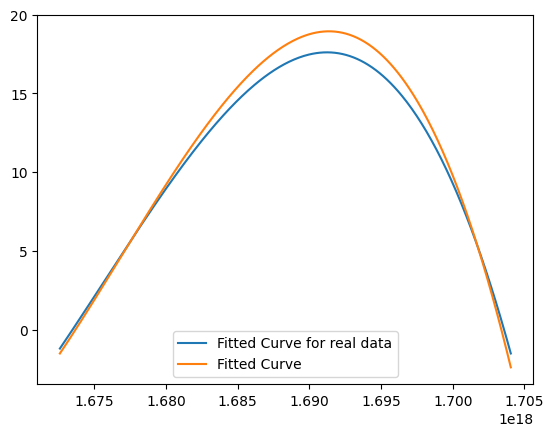

In [22]:
popt1, pcov1 = curve_fit(polynomial, time, real_values )
popt, pcov = curve_fit(polynomial, time, values )

plt.plot(time, polynomial(time, *popt1), label='Fitted Curve for real data')
plt.plot(time, polynomial(time, *popt), label='Fitted Curve')
plt.legend()
plt.show()